# Imports

In [ ]:
# %pip install -r requirements.txt

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
from scipy.spatial.distance import pdist
import chess
import chess.svg
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, SVG

# Import UDFs

In [2]:
from models import train_board_detection, train_piece_detection
from chess_utils import count_vertical_boundaries, count_horizontal_boundaries, df_to_fen, complete_grid, draw_infinite_grid, flexible_priority_assignments, reorient_board
from stockfish_utils import get_best_move, display_eval

# Train the models

In [3]:
# Uncomment to retrain the models

# train_board_detection()
# train_piece_detection()

### Chessboard Detection and Grid Extraction using YOLO

This cell loads an image, applies a YOLO-based chessboard detection model, and extracts grid intersections to define the chessboard structure.

#### **1. Loading the Image**
- The image is read from the specified file path using OpenCV (`cv2.imread`).
- A copy of the original image is stored (`image_original`) to preserve the raw input for further processing.
- The original dimensions (`original_h`, `original_w`) are extracted for later rescaling.

#### **2. Loading and Running the YOLO Board Detection Model**
- The YOLO model for detecting chessboard crossings is loaded from `"runs/detect/train/weights/best.pt"`.
- Inference is run on the image (`model_board(image, iou=0.3)`) to detect key points representing board intersections.
- The Intersection Over Union (IoU) threshold is set to `0.3` to filter out duplicate detections and reduce false positives.
- The results are displayed to visualize detected crossings.

#### **3. Mapping Detected Crossings to the Original Image**
- The detected bounding boxes from YOLO are processed to compute their center points (`x_center`, `y_center`).
- These center points are rescaled back to the original image dimensions using width and height ratios.

#### **4. Structuring the Chessboard Grid**
- The detected crossing points are stored in a NumPy array for further processing.
- To impose a structured order on the crossings, they are sorted first by their `y` coordinate and then by their `x` coordinate, ensuring a proper row-wise arrangement.
- The **diagonal distance between squares** is estimated using pairwise Euclidean distances (`pdist`) and divided by 6 to approximate individual square sizes.

**Outcome:**  
This step extracts and processes the key points needed to construct the chessboard grid, which will later be used for accurate square detection and piece placement.


In [4]:
# Define image path
image_path = "chessboard.jpg"

# Load the original image
image = cv2.imread(image_path)
image_original = image.copy()
original_h, original_w = image.shape[:2]  # Get original image dimensions


0: 480x480 49 xcorners, 27.7ms
Speed: 4.4ms preprocess, 27.7ms inference, 968.3ms postprocess per image at shape (1, 3, 480, 480)


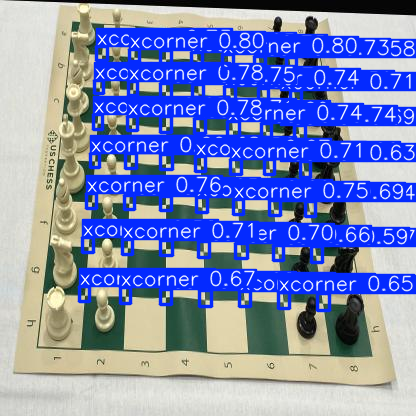

In [5]:
# Load the trained board detection model
model_board = YOLO("runs/detect/train/weights/best.pt")

# Run inference (YOLO automatically resizes input)
results = model_board(image, iou=0.3)[0]  # Get first result batch, iou to reduce false positives reoving same point beign detected multiple times

results.show()

# Get YOLO's input size (from inference logs)
yolo_input_h, yolo_input_w = results.orig_shape

# Extract detected crossings and correctly map them to the original size
crossings = []
for box in results.boxes.data:
    x_min, y_min, x_max, y_max, conf, cls = box.cpu().numpy()

    # Compute the center of the detected crossing
    x_center = (x_min + x_max)/2
    y_center = (y_min + y_max)/2

    # **Map back to original image size**
    x_center = int(x_center * (original_w / yolo_input_w))  # Width scaling
    y_center = int(y_center * (original_h / yolo_input_h))  # Height scaling

    crossings.append((x_center, y_center))  # Save corrected points

# Convert to NumPy array
crossings = np.array(crossings)

# Sort crossings to structure them into an 8x8 grid
crossings = sorted(crossings, key=lambda p: (p[1], p[0]))  # Sort by y, then x

# Find the diagonal distance of the squares
diag_distance = np.max(pdist(crossings, metric='euclidean'))/6

### Chessboard Grid Completion and Infinite Extension

This cell performs several key operations to generate and visualize an infinite chessboard grid based on detected intersections.

#### **1. Generating a Complete Grid**
The function `complete_grid()` takes the detected crossings from the chessboard and ensures a structured \(7 \times 7\) grid of intersection points is formed. Missing intersections are estimated using interpolation.

#### **2. Computing Infinite Line Equations**
The function `compute_line_equation(p1, p2, img_shape)` extends each grid line beyond the detected board area to span the entire image. It calculates the equation of a line passing through two points and determines its intersections with the image boundaries.

- If the line is vertical, it is extended along the image height.
- Otherwise, the function computes the line’s slope and y-intercept, then finds where it intersects the image’s left, right, top, and bottom borders.

#### **3. Drawing the Infinite Grid**
The function `draw_infinite_grid(image, grid)` extends the detected grid to cover the full image by:
- Extending each **horizontal** row to the left and right edges.
- Extending each **vertical** column to the top and bottom edges.
- Drawing the extended lines on the image using OpenCV.

#### **4. Visualization**
The final image, with infinite grid lines overlaid, is displayed using `matplotlib`. This helps ensure that the chessboard structure remains clear and well-aligned, even if some intersections were not initially detected.

**Outcome:**  
The resulting visualization shows the chessboard with an extended grid, allowing further processing, such as accurate piece detection and square attribution.


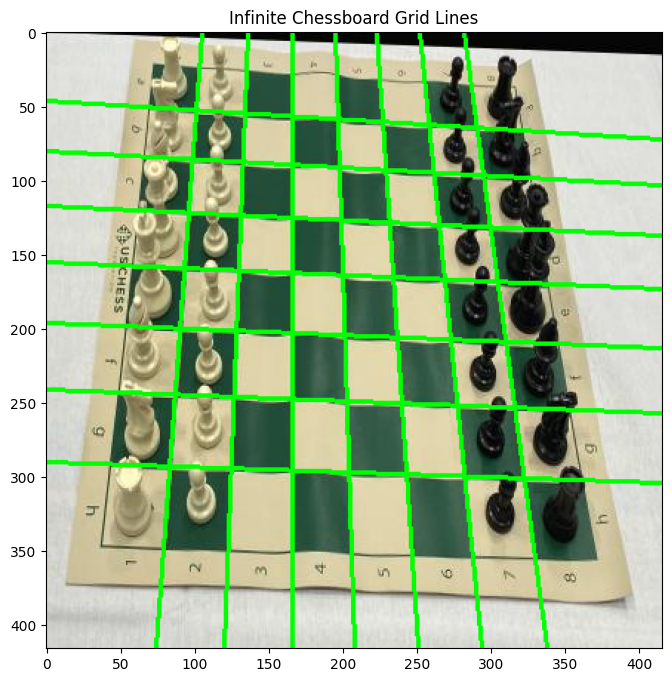

In [6]:
# Generate complete grid
grid = complete_grid(crossings, image.shape)

# Draw infinite lines
image_with_infinite_grid, horizontal_lines, vertical_lines = draw_infinite_grid(image, grid)

# Display final image
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image_with_infinite_grid, cv2.COLOR_BGR2RGB))
plt.title("Infinite Chessboard Grid Lines")
plt.show()

### Chessboard Bounding Box Detection and Cropping

This cell identifies the chessboard area in the image and crops it for further processing.

#### **1. Finding the Bounding Box for the Chessboard**
- The detected crossing points (`crossings`) are used to determine the **minimum and maximum** x and y coordinates.
- These values define the smallest bounding box that fully contains all detected intersections.

#### **2. Expanding the Bounding Box**
- To ensure pieces near the edges are not cut off, the bounding box is expanded slightly.
- The expansion amount is based on the estimated diagonal distance of a square (`diag_distance * 1.25`).
- The new bounding box coordinates are adjusted to stay within the image bounds using `max()` and `min()`.

#### **3. Cropping the Image**
- The original image is cropped using the adjusted bounding box coordinates.
- The resulting `cropped_image_original` contains only the chessboard region, ensuring a focused area for subsequent piece detection.

**Outcome:**  
This step extracts a properly bounded chessboard region, minimizing unwanted background while keeping all chess pieces visible.


In [7]:
# **Step 1: Find Bounding Box for Chessboard**
min_x, min_y = np.min(crossings, axis=0)  # Smallest x and y
max_x, max_y = np.max(crossings, axis=0)  # Largest x and y

# **Step 2: Expand Bounding Box Slightly (to avoid cutting pieces)**
padding = int(diag_distance*1.25)
min_x_chessboard, min_y_chessboard = max(0, min_x - padding), max(0, min_y - padding)
max_x_chessboard, max_y_chessboard = min(image_original.shape[1], max_x + padding), min(image_original.shape[0], max_y + padding)

# **Step 3: Crop the image_original**
cropped_image_original = image_original[min_y_chessboard:max_y_chessboard, min_x_chessboard:max_x_chessboard]

### Chess Piece Detection using YOLO

This cell loads a pre-trained YOLO model to detect chess pieces in the cropped chessboard image.

#### **1. Loading the Trained Chess Piece Detection Model**
- A YOLO model trained specifically for detecting chess pieces is loaded from `"runs/detect_pieces/train/best.pt"`.
- This model has been fine-tuned to recognize different chess piece types based on prior training.

#### **2. Running Inference for Piece Detection**
- The model is applied to the **cropped chessboard image** (`cropped_image_original`), ensuring detection focuses only on the board.
- The IoU (Intersection Over Union) threshold is set to `0.2`, reducing false positives by filtering overlapping detections.

#### **3. Displaying Detection Results**
- The detected pieces are displayed using `results_pieces.show()`, visually confirming the model’s output.

**Outcome:**  
This step identifies the chess pieces present on the board and prepares their bounding box information for further processing, such as mapping them to specific squares.



0: 480x480 2 black-bishops, 2 black-kings, 2 black-knights, 8 black-pawns, 2 black-queens, 2 black-rooks, 2 white-bishops, 1 white-king, 2 white-knights, 8 white-pawns, 1 white-queen, 2 white-rooks, 45.0ms
Speed: 4.7ms preprocess, 45.0ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 480)


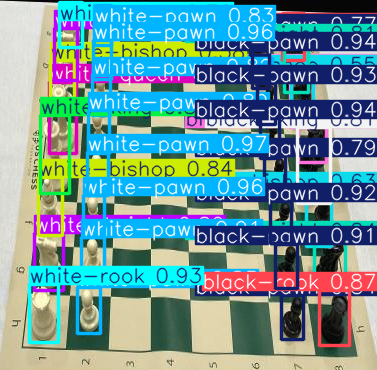

In [8]:
# Load trained chess piece detection model
model_pieces = YOLO("runs/detect_pieces/train/best.pt")  

# Run inference for pieces
results_pieces = model_pieces(cropped_image_original, iou=0.1)[0]
results_pieces.show()


### Extracting Detected Chess Pieces and Their Locations

This cell processes the output from the YOLO chess piece detection model to identify and localize each detected piece.

#### **1. Extracting Piece Names**
- The trained YOLO model contains class labels for different chess pieces.
- `piece_names = model_pieces.model.names` dynamically retrieves the mapping of class indices to piece names.

#### **2. Processing Detection Results**
- Each detected piece is represented by a bounding box (`x_min, y_min, x_max, y_max`).
- The **center of the bounding box** is computed as:
  \[
  \text{piece\_center} = \left( \frac{x_{\text{min}} + x_{\text{max}}}{2}, \frac{y_{\text{min}} + y_{\text{max}}}{2} \right)
  \]
  This ensures each piece is assigned to a single board square.
- The detected coordinates are mapped back to the original chessboard position by adding `min_x_chessboard` and `min_y_chessboard` (which account for the earlier cropping step).

#### **3. Assigning Class Labels**
- Each detected piece has a **class index** (`cls`), which is converted to a human-readable name using `piece_names[class_label]`.
- The detected piece and its computed center position are stored in the `pieces` list as tuples:  
  ```python
  pieces.append((piece_center, piece_name))
  ```

**Outcome:**
This step translates YOLO’s raw detection outputs into meaningful chess piece positions, enabling accurate mapping to board squares in the next processing phase.


In [9]:
# Extract piece names dynamically
piece_names = model_pieces.model.names  

# Extract detected pieces
pieces = []
for box in results_pieces.boxes.data:
    x_min, y_min, x_max, y_max, conf, cls = box.cpu().numpy()
    piece_center = (int((x_min + x_max + diag_distance/2) // 2 + min_x_chessboard), int((y_min + y_max + diag_distance/2) // 2 + min_y_chessboard))  # Center of piece
    class_label = int(cls)  # Class ID
    piece_name = piece_names[class_label]  # Get name from YOLO model
    pieces.append((piece_center, piece_name))

### Assigning Chess Pieces to Board Squares

This cell determines the correct chessboard square for each detected piece by computing how many vertical and horizontal grid boundaries each piece center crosses.

#### **1. Computing Intersections with Grid Lines**
Two functions calculate where an imaginary horizontal or vertical line through a piece intersects the grid lines:
- **`intersect_horizontal_line_with_line(grid_line, y_val)`**:  
  - Computes the **x-coordinate** where a given **horizontal line** (at `y = piece_center[1]`) intersects a vertical grid line.
  - If the grid line is nearly vertical, it returns the x-coordinate directly.
  - If the grid line is nearly horizontal, it returns `None` (since no valid intersection exists).

- **`intersect_vertical_line_with_line(grid_line, x_val)`**:  
  - Computes the **y-coordinate** where a given **vertical line** (at `x = piece_center[0]`) intersects a horizontal grid line.
  - Similar logic applies to handle nearly horizontal or vertical lines.

#### **2. Counting Boundaries to Determine Square Index**
Each piece’s position is mapped to a chess square by counting grid crossings:
- **`count_vertical_boundaries(piece_center, vertical_lines)`**:  
  - Counts how many vertical grid lines a horizontal line through the piece’s center intersects to its left.
  - This determines the **column (file) index** on the chessboard.

- **`count_horizontal_boundaries(piece_center, horizontal_lines)`**:  
  - Counts how many horizontal grid lines a vertical line through the piece’s center intersects above it.
  - This determines the **row (rank) index** on the chessboard.

#### **3. Mapping Pieces to Chess Notation**
- The chessboard is represented as an `8×8` NumPy array (`chessboard`), initialized with empty strings.
- **Chess notation mappings**:
  - **Ranks (rows)** are labeled **1-8** (bottom to top).
  - **Files (columns)** are labeled **h-a** (right to left) to align with chessboard orientation.

Each piece's computed indices are **clamped within valid bounds (0 to 7)** to prevent errors. The final chess notation is determined as:
\[
\text{square\_name} = \text{cols_labels[col_index]} + \text{rows_labels[row_index]}
\]

Each detected piece is assigned to its corresponding square in the `chessboard` array.

#### **4. Resolves conflicts in square assignments by prioritizing piece placement.**
  - **If there is no conflict** (only one piece assigned to a square), it is kept.
  - **If multiple pieces are detected on the same square:**
    - Kings are deprioritized if there are non-king candidates.
    - If a piece type has not yet been placed anywhere on the board, it gets priority.
    - If all piece types are already placed, the one with the highest predefined priority (lowest value in `flexible_priority`) is chosen.
    - Among flexible pieces, bishops are preferred over queens, followed by rooks and knights.

#### **5. Visualization**
- **Red dots** are drawn at each piece’s detected center to verify their positions.
- The processed chessboard, with pieces mapped to squares, is displayed using `matplotlib`.

**Outcome:**  
This step successfully assigns pieces to squares based on their positions relative to the board’s detected grid, ensuring accurate placement in chess notation.


Piece: white-pawn at (126, 187) → Assigned to Square: g5
Piece: white-pawn at (131, 73) → Assigned to Square: g2
Piece: white-pawn at (123, 230) → Assigned to Square: g6
Piece: black-pawn at (298, 152) → Assigned to Square: b4
Piece: black-pawn at (290, 83) → Assigned to Square: b2
Piece: white-rook at (72, 327) → Assigned to Square: h8
Piece: black-pawn at (295, 117) → Assigned to Square: b3
Piece: black-pawn at (309, 236) → Assigned to Square: b6
Piece: black-pawn at (315, 280) → Assigned to Square: b7
Piece: white-pawn at (122, 273) → Assigned to Square: g7
Piece: white-pawn at (127, 145) → Assigned to Square: g4
Piece: black-rook at (363, 331) → Assigned to Square: a8
Piece: white-king at (84, 168) → Assigned to Square: h5
Piece: black-pawn at (321, 331) → Assigned to Square: b8
Piece: black-knight at (358, 279) → Assigned to Square: a7
Piece: white-bishop at (79, 220) → Assigned to Square: h6
Piece: white-pawn at (131, 39) → Assigned to Square: g1
Piece: white-pawn at (117, 324) →

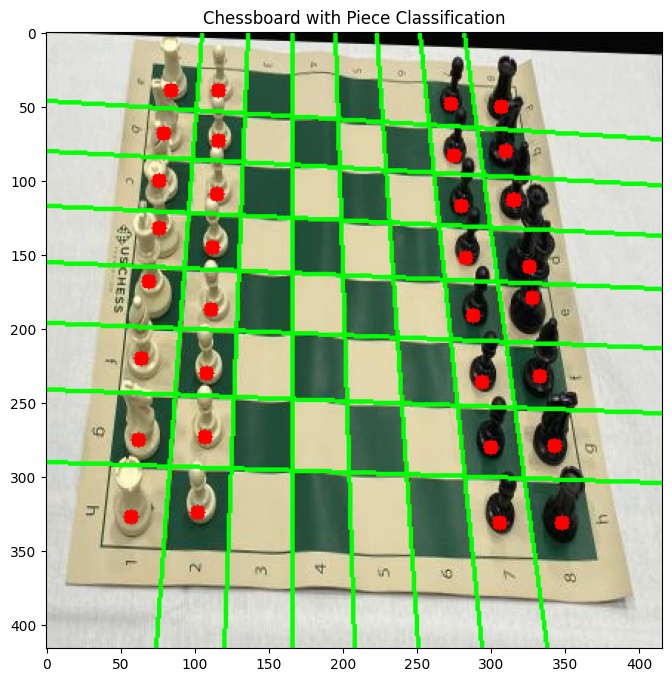

In [10]:
# **Chess notation mappings** (these are just for referencing, not acutally right)
rows_labels = ['1', '2', '3', '4', '5', '6', '7', '8']  # Rank (bottom to top)
cols_labels = ['h', 'g', 'f', 'e', 'd', 'c', 'b', 'a']  # File (left to right)

# Initialize an 8x8 chessboard
chessboard = np.full((8, 8), "", dtype=object)

square_assignments = {}

for piece_center, piece_name in pieces:
    # Compute board indices from the piece's center
    col_index = count_vertical_boundaries(piece_center, vertical_lines)
    row_index = count_horizontal_boundaries(piece_center, horizontal_lines)
    col_index = min(max(col_index, 0), 7)
    row_index = min(max(row_index, 0), 7)
    square_name = f"{cols_labels[col_index]}{rows_labels[row_index]}"
    
    # Store all assignments for each square (multiple detections can land on the same square)
    if square_name not in square_assignments:
        square_assignments[square_name] = []
    square_assignments[square_name].append((piece_name, piece_center))
    
    print(f"Piece: {piece_name} at {piece_center} → Assigned to Square: {square_name}")

# To resolve conflicts if any
final_assignments = flexible_priority_assignments(square_assignments)

# Finally, update the chessboard array based on the resolved assignments.
for square, (piece_name, piece_center) in final_assignments.items():
    # Determine row and column indices based on the square name.
    # (Assuming cols_labels and rows_labels were defined earlier.)
    col_index = cols_labels.index(square[0])
    row_index = rows_labels.index(square[1])
    chessboard[row_index, col_index] = piece_name

for piece_center, _ in pieces:
    adjusted_center = (
        piece_center[0] - min_x_chessboard,
        piece_center[1] - min_y_chessboard
    )
    cv2.circle(image, adjusted_center, 5, (0, 0, 255), -1)  # Draw on cropped image

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Chessboard with Piece Classification")
plt.show()


### Converting the Detected Chessboard to FEN and Displaying It

This cell transforms the detected chessboard representation into **Forsyth-Edwards Notation (FEN)**, a standard format for describing chess positions, and then visualizes it using `python-chess`.

---

#### **1. Reorients an 8x8 chessboard (as a NumPy matrix) so that White pieces are at the bottom (higher row indices) and Black pieces are at the top (lower row indices).**

Tests all 4 possible rotations (0°, 90°, 180°, 270°) and selects the one where the white pieces are positioned as far down as possible relative to the black pieces. It does this by computing, for each rotation, the difference between the minimum row index of all White pieces and the maximum row index of all Black pieces. (Rows are numbered 0 (top) to 7 (bottom).)


---

#### **2. Mapping Chess Piece Names to FEN Symbols**
A dictionary `piece_to_fen` is created to convert detected piece names (e.g., `"white-queen"`, `"black-pawn"`) into their corresponding FEN notation symbols:
- **Uppercase** represents **White pieces** (e.g., `"Q"` for White Queen).
- **Lowercase** represents **Black pieces** (e.g., `"q"` for Black Queen).

---

#### **3. Converting the Chessboard DataFrame to a FEN String**
The function `df_to_fen(df, mapping)` transforms a **pandas DataFrame** (where each cell contains a piece name or an empty string) into a **FEN-compliant board string**:
1. **Flipping the Board (`df.iloc[::-1]`)**:  
   - The DataFrame is flipped **vertically** to match FEN’s convention, where **rank 8 is at the top** and **rank 1 is at the bottom**.
   
2. **Iterating Through Rows (Ranks)**:  
   - Empty squares are counted and represented by numbers in FEN (e.g., `"3"` means three empty squares).
   - Non-empty squares are replaced with their **FEN piece symbols** using the provided mapping.

3. **Joining Rows with `/`**:  
   - The final FEN board string is formed by joining rank strings with `/`.

---

#### **4. Constructing the Full FEN String**
A **complete FEN string** includes additional information:
- `"w"` → White to move.
- `"-"` → No castling rights.
- `"-"` → No en passant target square.
- `"0"` → Halfmove clock (for draw rules).
- `"1"` → Move number.

The final FEN is formatted as:
```python
full_fen = f"{fen_position} w - - 0 1"
```

#### **5. Creating and Displaying the Chessboard**
- A `python-chess` **Board object** is created from the FEN string.
- The board is rendered as an **SVG image** using `chess.svg.board()`.
- The result is displayed in Jupyter Notebook using `display(SVG(svg_board))`.


**Outcome:**
This cell successfully converts the detected chessboard to FEN notation, reconstructs a valid chess position, and visualizes it as an interactive chessboard.

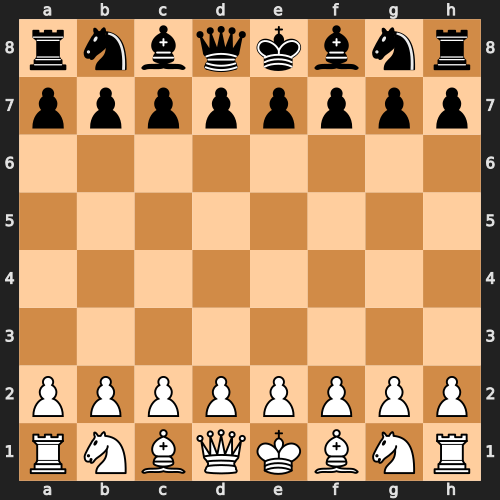

In [ ]:
# Reorient the board according to some heuristics so that white is on the bottom
corrected_chessboard = reorient_board(chessboard)
corrected_df = pd.DataFrame(corrected_chessboard, index=range(8, 0, -1), columns=list("abcdefgh"))

# Convert the DataFrame to a FEN string for the board position.
fen_position = df_to_fen(corrected_df)

# A full FEN includes additional fields. Here we assume:
# - White to move ("w")
# - No castling availability ("-")
# - No en passant target square ("-")
# - 0 halfmove clock, and move number 1
full_fen_w = f"{fen_position} w - - 0 1"
full_fen_b = f"{fen_position} b - - 0 1"

# Create a python-chess board from the FEN
board = chess.Board(full_fen_w)

# Display the board as an SVG
svg_board = chess.svg.board(board, size=500)  # You can adjust the size

# Show in Jupyter Notebook or interactive environment
display(SVG(svg_board))

# The following only works on Windows and Linux

### StockFish-Based Evaluation Functions

These functions utilize the StockFish engine to determine the best move, tailored to whether White or Black is on turn. 

They also provide chess metrics that evaluate the position in centipawns (1/100 of the value of a pawn). In a balanced position (e.g., the starting position), the score is 0, indicating no advantage. 

In unbalanced positions, a positive score signifies an advantage for White, while a negative score indicates an advantage for Black. For example a score of +1 means that white's advantage is equal to having one extra pawn on the board compared to black, despite perhaps not having captured extra material.


### Chess Evaluation Metrics

- **Material:**  
  Reflects the overall material balance between the two sides, using standard piece values (e.g., pawn=1, knight/bishop=3, rook=5, queen=9).

- **Imbalance:**  
  Measures differences in the distribution and type of material, capturing nuances beyond the simple material count.

- **Pawns:**  
  Evaluates the pawn structure, including the number of pawns and issues such as doubled, isolated, or passed pawns.

- **Knights:**  
  Assesses the activity and potential of knights, considering their positioning and ability to exploit outposts.

- **Bishops:**  
  Measures bishop activity and effectiveness, including their control over long diagonals and the benefits of having the bishop pair.

- **Rooks:**  
  Evaluates rooks based on their activity, control of open files, and overall contribution to board pressure.

- **Queens:**  
  Reflects the queen’s power and versatility in both offense and defense, influencing overall position dynamics.

- **Mobility:**  
  Quantifies the number of legal moves available to each side, indicating how active and dynamic the pieces are.

- **King Safety:**  
  Assesses how well the king is protected, including factors like pawn cover and exposure to potential attacks.

- **Threats:**  
  Measures the potential to create or execute tactical threats against the opponent’s pieces or key squares.

- **Passed:**  
  Evaluates the presence and potential impact of passed pawns, which can be critical in endgame scenarios.

- **Space:**  
  Assesses spatial control over the board, indicating which side dominates key squares and regions.

- **Winnable:**  
  Provides a heuristic evaluation of whether the position appears to be winning or losing, beyond material and positional factors.

- **Total:**  
  The aggregate evaluation of the position, summing all individual metrics to yield an overall score (in centipawns).


#### If white to play

In [ ]:
# Calculates the optimal move for White based on the current position described by `full_fen_w` 
# Uses the Stockfish 15 engine in order to find it.
best_move_white = get_best_move(full_fen_w)

# Print out the recommended move
print("Best move for white:", best_move_white)

# Displays the chess board with the recommended move in blue along wiht 
# a detailed evaluation of the position after the best move, including various chess metrics.
display_eval(full_fen_w, best_move_white)

Best move for white: e2e4


#### If black to play

In [ ]:
# Calculates the optimal move for White based on the current position described by `full_fen_w` 
# Uses the Stockfish 15 engine in order to find it.
best_move_black = get_best_move(full_fen_b)

# Print out the recommended move
print("Best move for white:", best_move_black)

# Displays the chess board with the recommended move in blue along wiht 
# a detailed evaluation of the position after the best move, including various chess metrics.
display_eval(full_fen_b, best_move_black)

Best move for white: e7e5
